Simple moving average provides less false positives for high volatility charts like BTC. 50 day SMA and 20 day SMA used to generate buy sell signals

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
df = pd.read_csv('BTC-USD.csv')
# set date as index
df = df.set_index(pd.DatetimeIndex(df['Date'].values))
df

,Date,Open,High,Low,Close,Volume
2019-12-08,2019-12-08,7551.338867,7634.606445,7476.091309,7564.345215,1.540991e+10
2019-12-09,2019-12-09,7561.795410,7618.091797,7365.985352,7400.899414,1.787202e+10
2019-12-10,2019-12-10,7397.134277,7424.022949,7246.043945,7278.119629,1.824903e+10
2019-12-11,2019-12-11,7277.197754,7324.156250,7195.527344,7217.427246,1.635049e+10
2019-12-12,2019-12-12,7216.738770,7266.639648,7164.741211,7243.134277,1.892708e+10
...,...,...,...,...,...,...
2021-12-04,2021-12-04,53727.878906,53904.679688,42874.617188,49200.703125,6.138568e+10
2021-12-05,2021-12-05,49201.519531,49768.148438,47857.496094,49368.847656,3.719820e+10
2021-12-06,2021-12-06,49413.480469,50929.519531,47281.035156,50582.625000,3.770731e+10
2021-12-07,2021-12-07,50581.828125,51934.781250,50175.808594,50700.085938,3.367681e+10


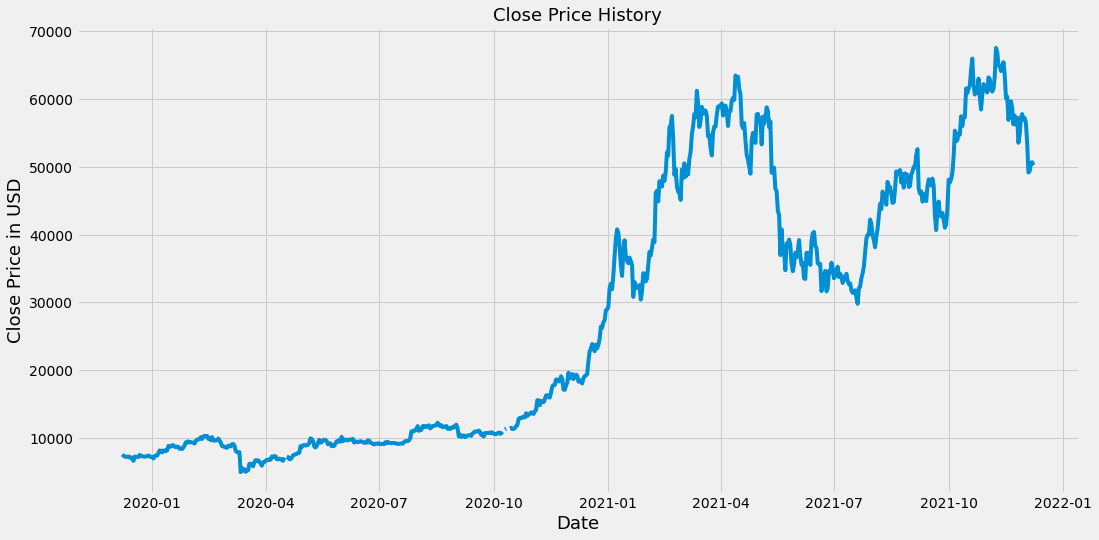

In [4]:
# View closing price
plt.figure(figsize=(16, 8))
plt.title('Close Price History', fontsize=18)
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price in USD', fontsize=18)
plt.show()

In [5]:
# Calculate SMA
def sma(data, period=30, column='Close'):
    return data[column].rolling(window=period).mean()

In [7]:
df['SMA20'] = sma(df, 20)
df['SMA50'] = sma(df, 50)

In [8]:
# Generate buy sell signal
df['Signal'] = np.where(df['SMA20'] > df['SMA50'], 1, 0)
#short term sma > long term sma (bullish) position will be 1, bearish will be -1
df['Position'] = df['Signal'].diff()

df['Buy_Signal_Price'] = np.where(df['Position'] == 1, df['Close'], np.nan)
df['Sell_Signal_Price'] = np.where(df['Position'] == -1, df['Close'], np.nan)

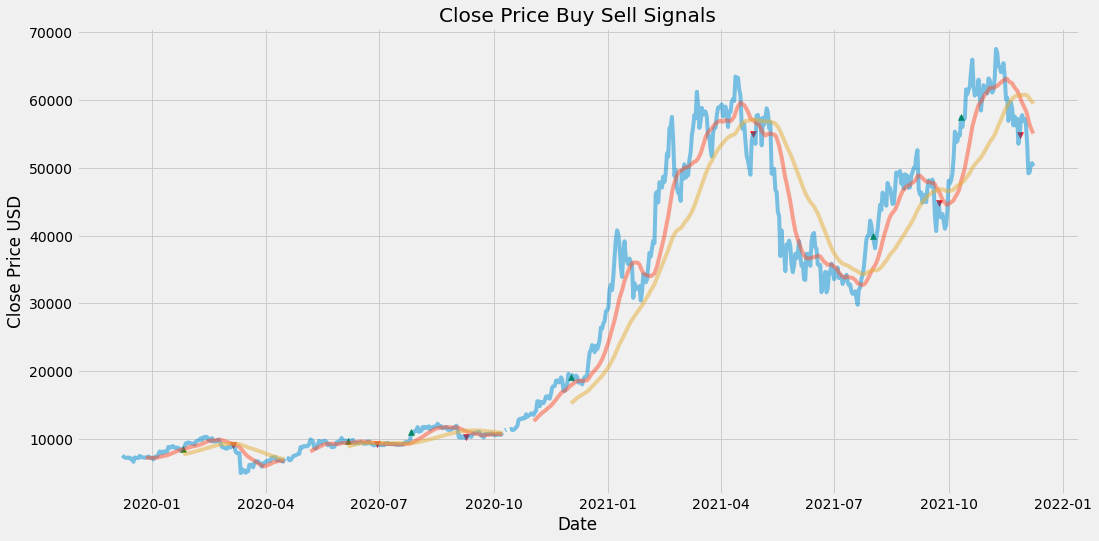

In [10]:
# Visualise buy sell signals
plt.figure(figsize=(16,8))
plt.title('Close Price Buy Sell Signals')
plt.plot(df['Close'], alpha=0.5, label='Close')
plt.plot(df['SMA20'], alpha=0.5, label='SMA20')
plt.plot(df['SMA50'], alpha=0.5, label='SMA50')
plt.scatter(df.index, df['Buy_Signal_Price'], color='green', label='Buy Signal', marker='^', alpha=1)
plt.scatter(df.index, df['Sell_Signal_Price'], color='red', label='Sell Signal', marker='v', alpha=1)
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

In [11]:
# Tabulate percentage gains
def tabuatePercentageGains(data):
    openPosition = False
    startingSum = 100
    quantityHeld = 0
    buyingPrice = 0
    for i in range(0, len(data.index)):
        buyPrice = data['Buy_Signal_Price'][i]
        sellPrice = data['Sell_Signal_Price'][i]
        if(not openPosition and not np.isnan(buyPrice)):
            quantityHeld = startingSum/buyPrice
            openPosition = True
            buyingPrice = buyPrice
            print(f"Buy at {buyPrice} USD")
        if(openPosition and not np.isnan(sellPrice)):
            startingSum = sellPrice * quantityHeld
            quantityHeld = 0
            openPosition = False
            print(f"Sell at {sellPrice} USD, portfolio:{startingSum}")
    
    if(openPosition):
        # Assume last open position was not taken since no selling price
        startingSum = quantityHeld * buyingPrice
        print(f"No selling price available, position at {buyingPrice} USD voided")
        
    percentageChange = startingSum - 100
    return percentageChange

percentageGained = tabuatePercentageGains(df)
print(f'Net Gain: {percentageGained}%')

Buy at 8596.830078 USD
Sell at 9122.545898 USD, portfolio:106.11522869743987
Buy at 9653.679688 USD
Sell at 9190.854492 USD, portfolio:101.02775914098389
Buy at 10990.873047 USD
Sell at 10242.347656 USD, portfolio:94.14733730465852
Buy at 19201.091797 USD
Sell at 55033.117188 USD, portfolio:269.83993939526687
Buy at 39974.894531 USD
Sell at 44895.097656 USD, portfolio:303.05246762427356
Buy at 57484.789063 USD
Sell at 54815.078125 USD, portfolio:288.97809245838874
Net Gain: 188.97809245838874%


In [12]:
# Compare to buy and hold
def buyAndHold(data):
    buyAt = data['Close'][0]
    sellAt = data['Close'][len(data.index)-1]
    return (sellAt - buyAt) * 100 / (buyAt)

performance = 100 * (percentageGained - buyAndHold(df)) / buyAndHold(df)
print(f'StochRSI outperform buy and hold by: {np.round(performance,3)}%')

StochRSI outperform buy and hold by: -66.531%


Closing thoughts: SMA appears to be a cautious indicator producing very few signals, falls drastically behind buy and hold strategy.